In [1]:
from utils import *
from tqdm import tqdm
import os
import math
import torch
import torchvision
%load_ext autoreload
%autoreload 2

In [2]:
sigma = 15 / 255
lamb = 0.15

--------------------------
--------------------------
# <center> **$TV-\ell_2$ Denoising for B&W Images**
--------------------------
--------------------------

In [3]:
that = np.load('models/TV_BW/that_tvbw.npy')
s = np.load('models/TV_BW/s_tvbw.npy')

In [4]:
hist, that_edges, s_edges = np.histogram2d(np.log10(that), np.log10(np.array(s)+1e-10), bins=200)
cumhist = np.cumsum(hist, axis=1)
cumhist /= np.where(cumhist[:, -1, None] == 0.0, 1.0, cumhist[:, -1, None])
quantiles = np.zeros(len(that_edges)-1)
for i in range(len(that_edges)-1):
    quantiles[i] = s_edges[np.searchsorted(cumhist[i], .9)]

/tmp/ipykernel_13278/1959528242.py:4: RuntimeWarning: divide by zero encountered in log10
  ax[0].imshow(np.log10(hist0.T), origin='lower', extent=(that_edges0[0], that_edges0[-1], s_edges0[0], s_edges0[-1]), aspect="auto")


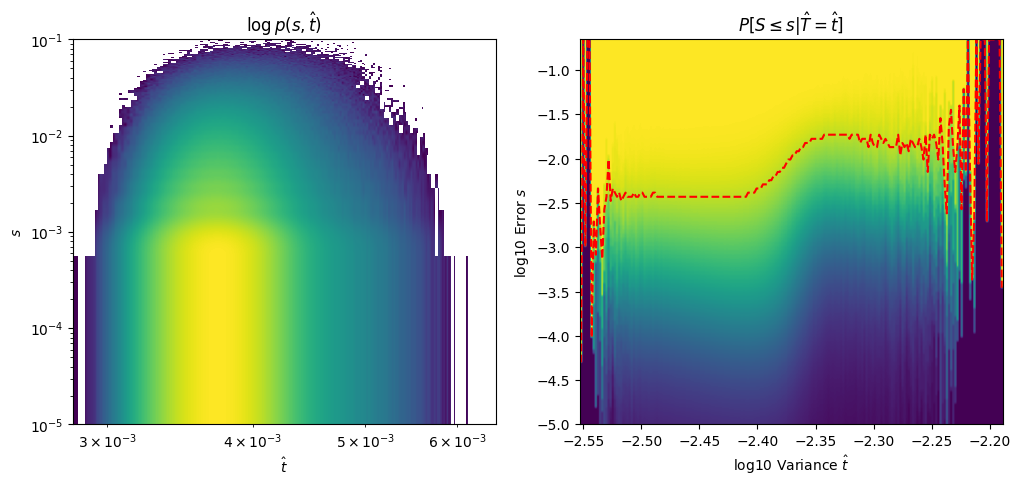

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

hist0, that_edges0, s_edges0 = np.histogram2d(that, s, bins=200)
ax[0].imshow(np.log10(hist0.T), origin='lower', extent=(that_edges0[0], that_edges0[-1], s_edges0[0], s_edges0[-1]), aspect="auto")
ax[0].set_xscale("log")
ax[0].set_xlabel("$\\hat{t}$")
ax[0].set_yscale("log")
ax[0].set_ylabel("$s$")
ax[0].set_ylim(1e-5, 1e-1)
ax[0].set_title("$\\log p(s, \\hat{t})$")

ax[1].imshow(cumhist.T, origin="lower", extent=(that_edges[0], that_edges[-1], s_edges[0], s_edges[-1]), aspect="auto")
ax[1].set_xlim(that_edges[0], that_edges[-1])
ax[1].set_xlabel("log10 Variance $\hat{t}$")
ax[1].set_ylim(-5.0, s_edges[-1])
ax[1].set_ylabel("log10 Error $s$")
ax[1].plot((that_edges[:-1] + that_edges[1:])/2, quantiles, color='red', linestyle="dashed")
ax[1].set_title("$P[S \\leq s | \\hat{T} = \\hat{t}]$")

plt.show()

In [6]:
nbins = 100
var_min = np.min(that)
var_max = np.max(that)
bin_step = (var_max-var_min)/nbins
errors_per_bin = [[] for _ in range(nbins)]
for i in range(len(that)):
    bin = min(nbins-1, int((that[i]-var_min)/bin_step))
    errors_per_bin[bin].append(s[i])
for bin in range(nbins):
    errors_per_bin[bin].sort()

In [7]:
def test_image(path, q=.9):
    u0 = torch.tensor(rgb2gray(plt.imread(path)))
    M, N = u0.size()
    z = u0 + sigma*torch.randn((M, N))
    xhat, variances = ulpda(z, torch.randn((M, N)), torch.randn((M, N, 2)), sigma, lamb, s_k=30, tau_k=1e-3, theta_k=1, K=3000, burnin=1000)
    estimated_errors = torch.zeros_like(xhat)
    for i in range(M):
        for j in range(N):
            bin = max(0, min(nbins-1, int((variances[i, j]-var_min)/bin_step)))
            quantile = math.ceil(q*(1+1/len(errors_per_bin[bin]))*len(errors_per_bin[bin]))-1
            quantile = min(len(errors_per_bin[bin])-1, max(0, quantile))
            estimated_errors[i, j] = errors_per_bin[bin][quantile]

    errors = (xhat - u0)**2

    coverage = torch.sum(errors <= estimated_errors)/torch.numel(errors)
    
    fig, ax = plt.subplots(1, 5, figsize=(20, 8))
    ax[0].imshow(u0, cmap="gray")
    ax[0].set_title("Ground truth")
    ax[0].axis("off")
    ax[1].imshow(z, cmap="gray")
    ax[1].set_title('Corrupted image \n (PSNR = ' + str2(psnr(u0, z)) + ' dB)')
    ax[1].axis("off")
    ax[2].imshow(xhat, cmap="gray")
    ax[2].set_title('MMSE estimator \n (PSNR = ' + str2(psnr(u0, xhat)) + ' dB)')
    ax[2].axis("off")
    ax[3].imshow(errors, vmin=0, vmax=0.02)
    ax[3].set_title('Reconstruction error')
    ax[3].axis("off")
    ax[4].imshow(estimated_errors, vmin=0, vmax=0.02)
    ax[4].set_title('Predicted Quantile $\hat{s}_{q}$ \n (coverage = ' + str2(coverage.item()*100) + '%)')
    ax[4].axis("off")
    cbar = fig.colorbar(ax[3].imshow(errors, vmin=0, vmax=0.02), ax=(ax[3], ax[4]), orientation='horizontal', ticks=[0, 0.01, 0.02])
    plt.show()

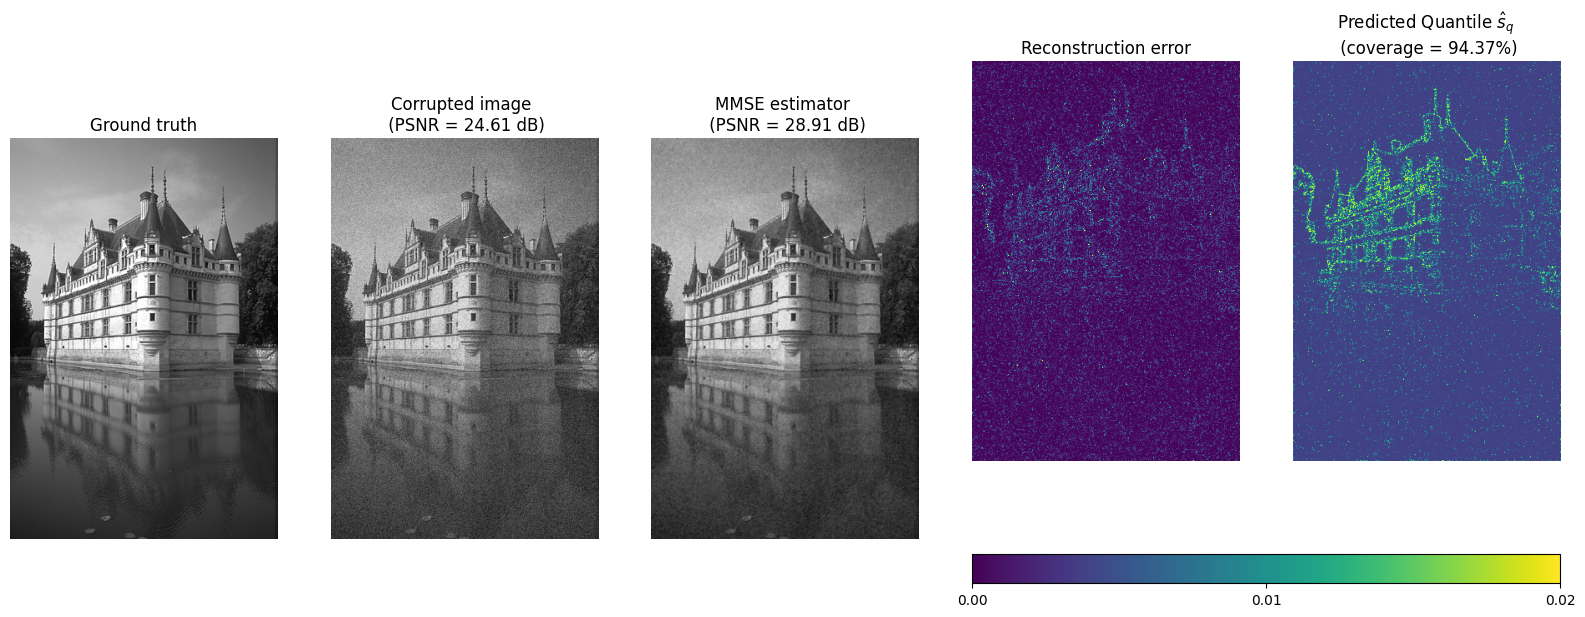

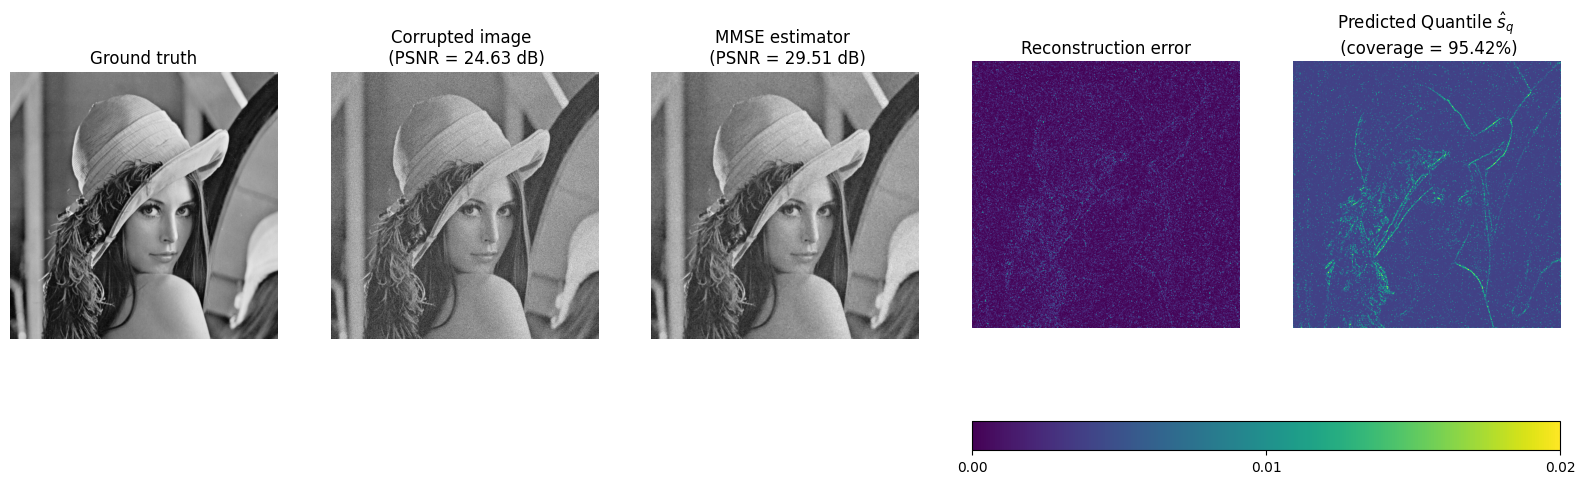

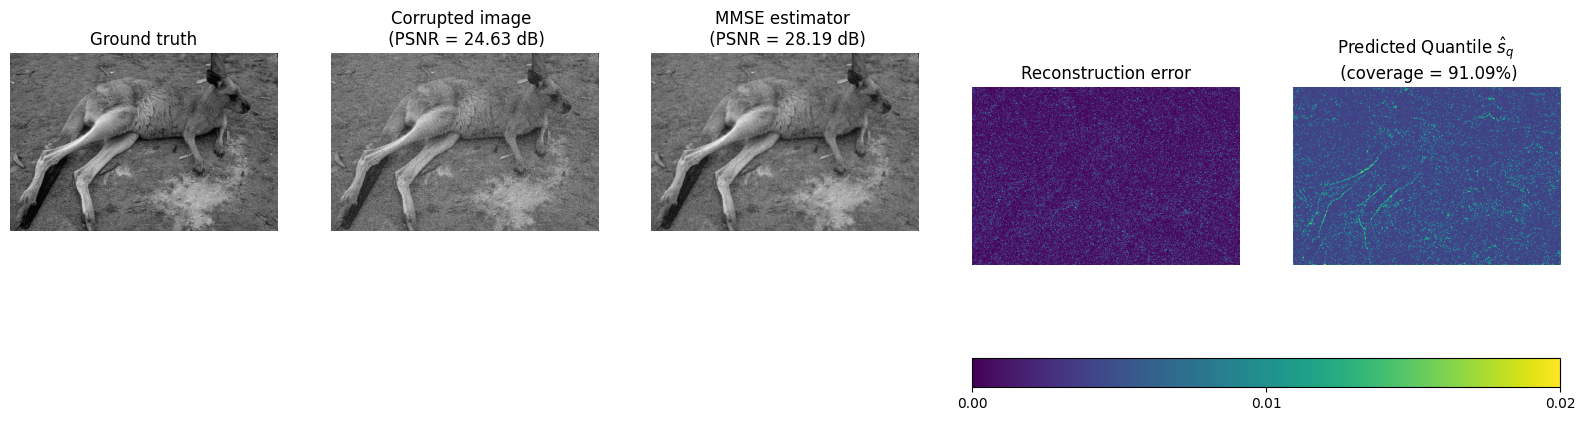

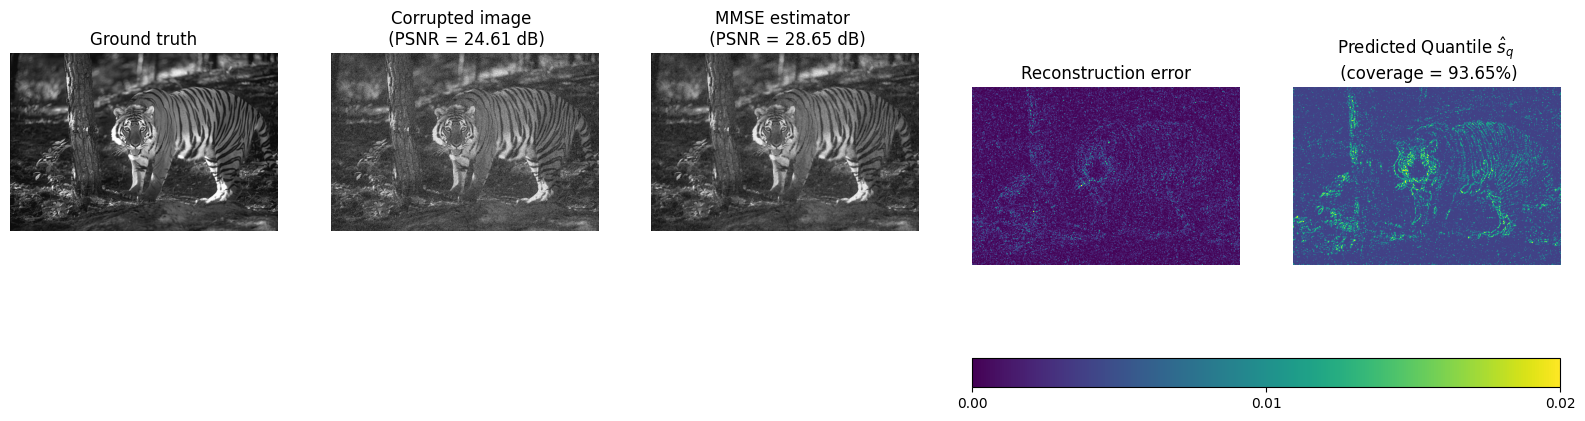

In [8]:
test_dir = "data/test"
for file in os.listdir(test_dir):
    if file.endswith(".png"):
        test_image(os.path.join(test_dir, file))

--------------------------
--------------------------
# <center> **$TV-\ell_2$ Denoising for RGB Images**
--------------------------
--------------------------

In [9]:
that = np.load('models/TV_RGB/that_rgb.npy')
s = np.load('models/TV_RGB/s_rgb.npy')

In [10]:
hist, that_edges, s_edges = np.histogram2d(np.log10(that), np.log10(np.array(s)+1e-10), bins=200)
cumhist = np.cumsum(hist, axis=1)
cumhist /= np.where(cumhist[:, -1, None] == 0.0, 1.0, cumhist[:, -1, None])
quantiles = np.zeros(len(that_edges)-1)
for i in range(len(that_edges)-1):
    quantiles[i] = s_edges[np.searchsorted(cumhist[i], .9)]

/tmp/ipykernel_13278/1959528242.py:4: RuntimeWarning: divide by zero encountered in log10
  ax[0].imshow(np.log10(hist0.T), origin='lower', extent=(that_edges0[0], that_edges0[-1], s_edges0[0], s_edges0[-1]), aspect="auto")


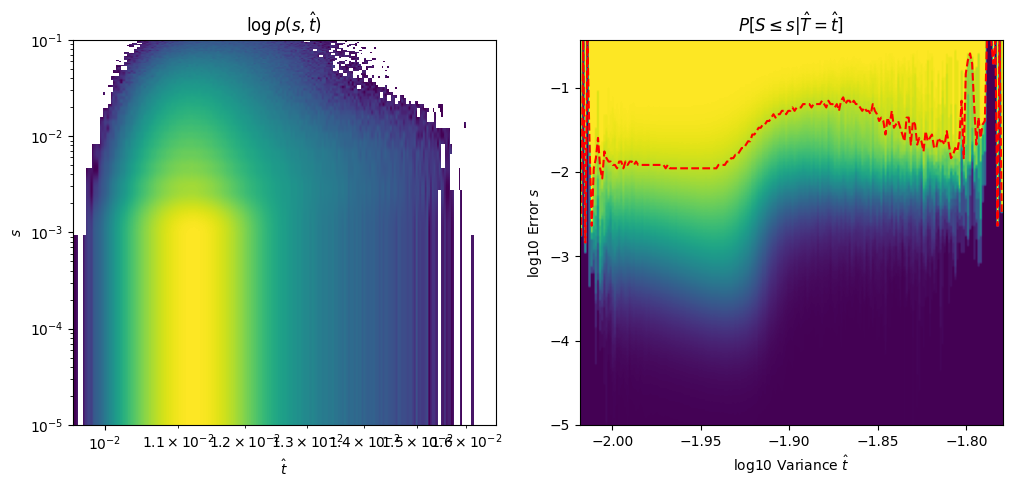

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

hist0, that_edges0, s_edges0 = np.histogram2d(that, s, bins=200)
ax[0].imshow(np.log10(hist0.T), origin='lower', extent=(that_edges0[0], that_edges0[-1], s_edges0[0], s_edges0[-1]), aspect="auto")
ax[0].set_xscale("log")
ax[0].set_xlabel("$\\hat{t}$")
ax[0].set_yscale("log")
ax[0].set_ylabel("$s$")
ax[0].set_ylim(1e-5, 1e-1)
ax[0].set_title("$\\log p(s, \\hat{t})$")

ax[1].imshow(cumhist.T, origin="lower", extent=(that_edges[0], that_edges[-1], s_edges[0], s_edges[-1]), aspect="auto")
ax[1].set_xlim(that_edges[0], that_edges[-1])
ax[1].set_xlabel("log10 Variance $\hat{t}$")
ax[1].set_ylim(-5.0, s_edges[-1])
ax[1].set_ylabel("log10 Error $s$")
ax[1].plot((that_edges[:-1] + that_edges[1:])/2, quantiles, color='red', linestyle="dashed")
ax[1].set_title("$P[S \\leq s | \\hat{T} = \\hat{t}]$")

plt.show()

In [12]:
nbins = 100
var_min = np.min(that)
var_max = np.max(that)
bin_step = (var_max-var_min)/nbins
errors_per_bin = [[] for _ in range(nbins)]
for i in range(len(that)):
    bin = min(nbins-1, int((that[i]-var_min)/bin_step))
    errors_per_bin[bin].append(s[i])
for bin in range(nbins):
    errors_per_bin[bin].sort()

In [13]:
def test_image_rgb(path, q=0.9):
    u0 = torch.tensor(plt.imread(path))
    M, N, _ = u0.size()
    z = u0 + sigma*torch.randn((M, N, 3))
    xhat, variances = ulpda_rgb(z, torch.randn((M, N, 3)), torch.randn((M, N, 3, 2)), sigma, lamb, s_k=30, tau_k=1e-3, theta_k=1, K=3000, burnin=1000)
    variances_pixelwise = torch.sum(variances, dim=-1)
    estimated_errors = torch.zeros((M, N))
    for i in range(M):
        for j in range(N):
            bin = max(0, min(nbins-1, int((variances_pixelwise[i, j]-var_min)/bin_step)))
            if len(errors_per_bin[bin]) == 0:
                estimated_errors[i, j] = 0
            else:
                quantile = math.ceil(q*(1+1/len(errors_per_bin[bin]))*len(errors_per_bin[bin]))-1
                quantile = min(len(errors_per_bin[bin])-1, max(0, quantile))
                estimated_errors[i, j] = errors_per_bin[bin][quantile]

    errors = (xhat - u0)**2
    errors_pixelwise = torch.sum(errors, dim=-1)
    
    coverage = torch.sum(errors_pixelwise <= estimated_errors)/torch.numel(errors_pixelwise)
    
    fig, ax = plt.subplots(1, 5, figsize=(20, 8))
    ax[0].imshow(u0, cmap="gray")
    ax[0].set_title("Ground truth")
    ax[0].axis("off")
    ax[1].imshow(z, cmap="gray")
    ax[1].set_title('Corrupted image \n (PSNR = ' + str2(psnr(u0, z)) + ' dB)')
    ax[1].axis("off")
    ax[2].imshow(xhat, cmap="gray")
    ax[2].set_title('MMSE estimator \n (PSNR = ' + str2(psnr(u0, xhat)) + ' dB)')
    ax[2].axis("off")
    ax[3].imshow(errors_pixelwise, vmin=0, vmax=0.06)
    ax[3].set_title('Reconstruction error')
    ax[3].axis("off")
    ax[4].imshow(estimated_errors, vmin=0, vmax=0.06)
    ax[4].set_title('Predicted Quantile $\hat{s}_{q}$ \n (coverage = ' + str2(coverage.item()*100) + '%)')
    ax[4].axis("off")
    cbar = fig.colorbar(ax[3].imshow(errors_pixelwise, vmin=0, vmax=0.06), ax=(ax[3], ax[4]), orientation='horizontal', ticks=[0, 0.03, 0.06])
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


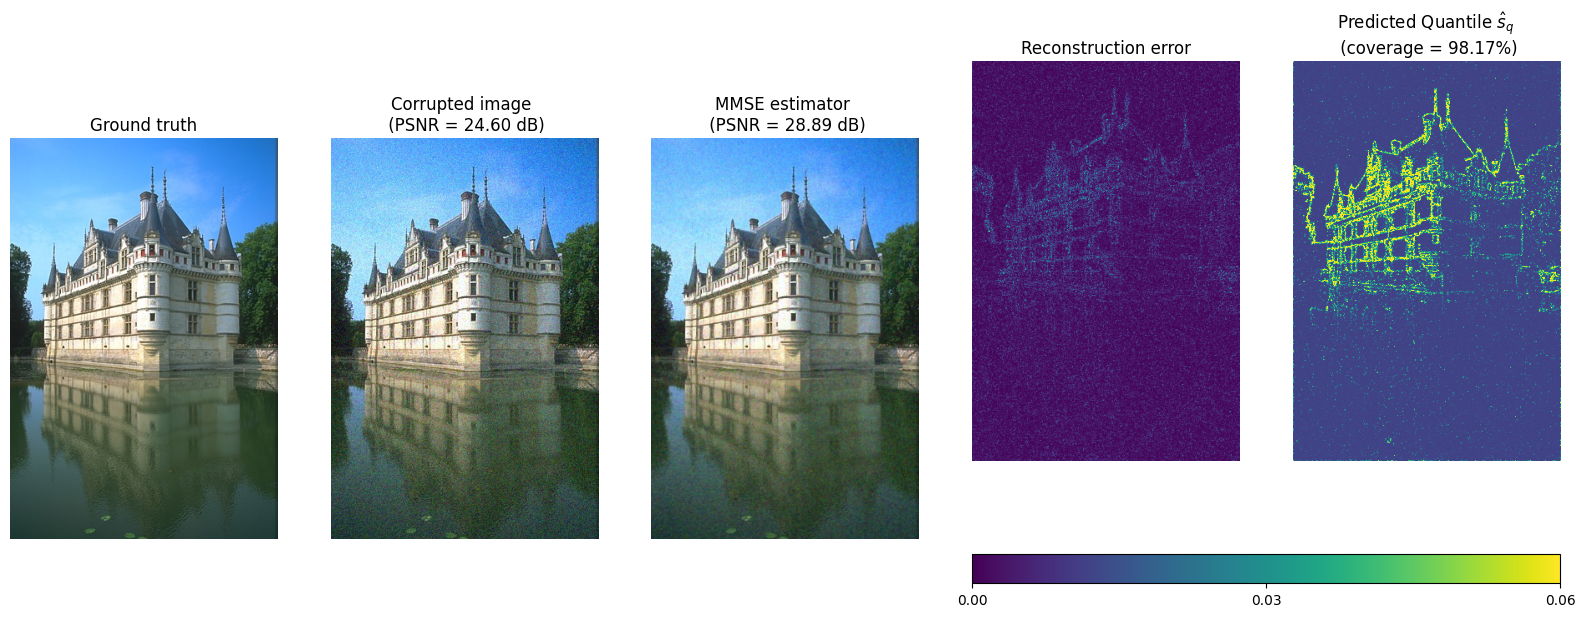

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


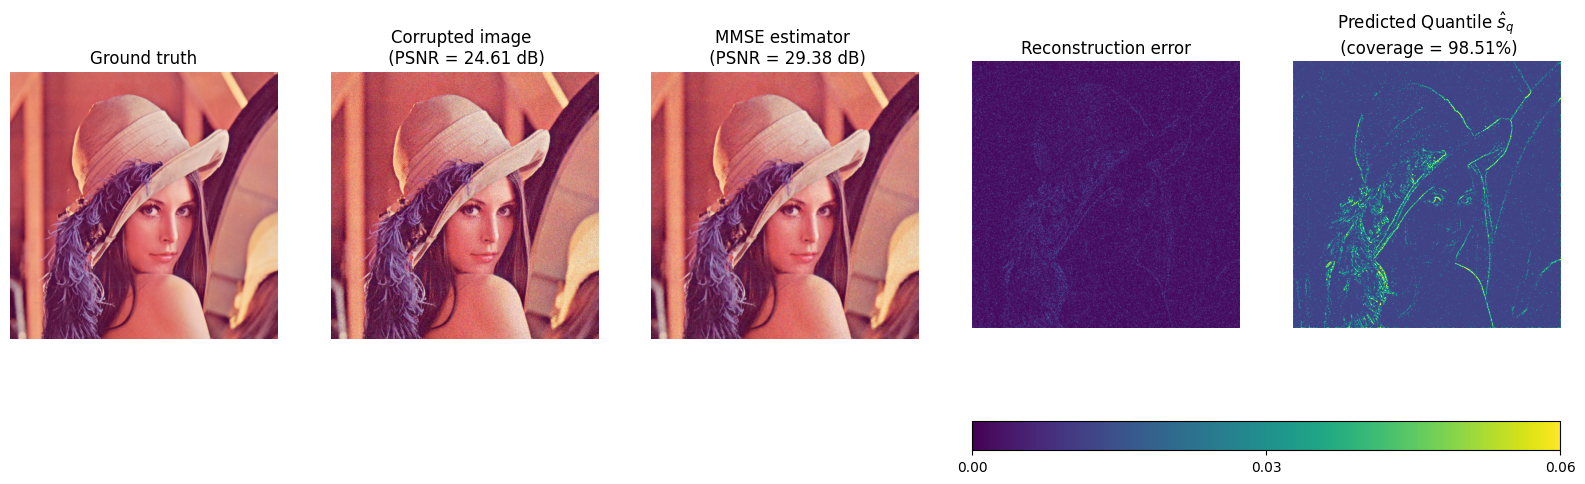

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


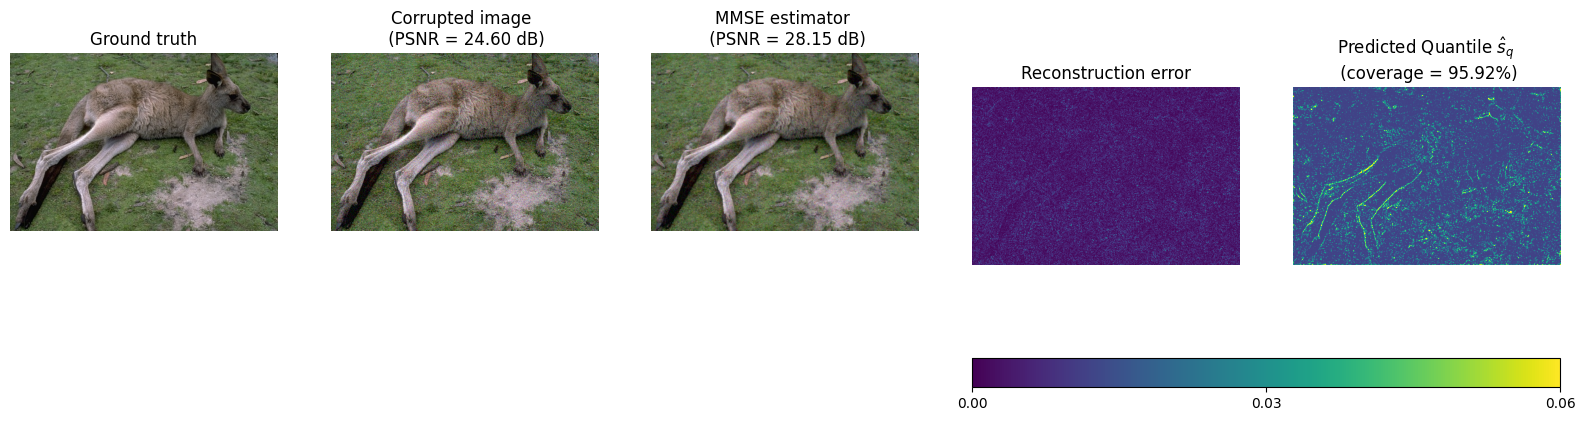

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


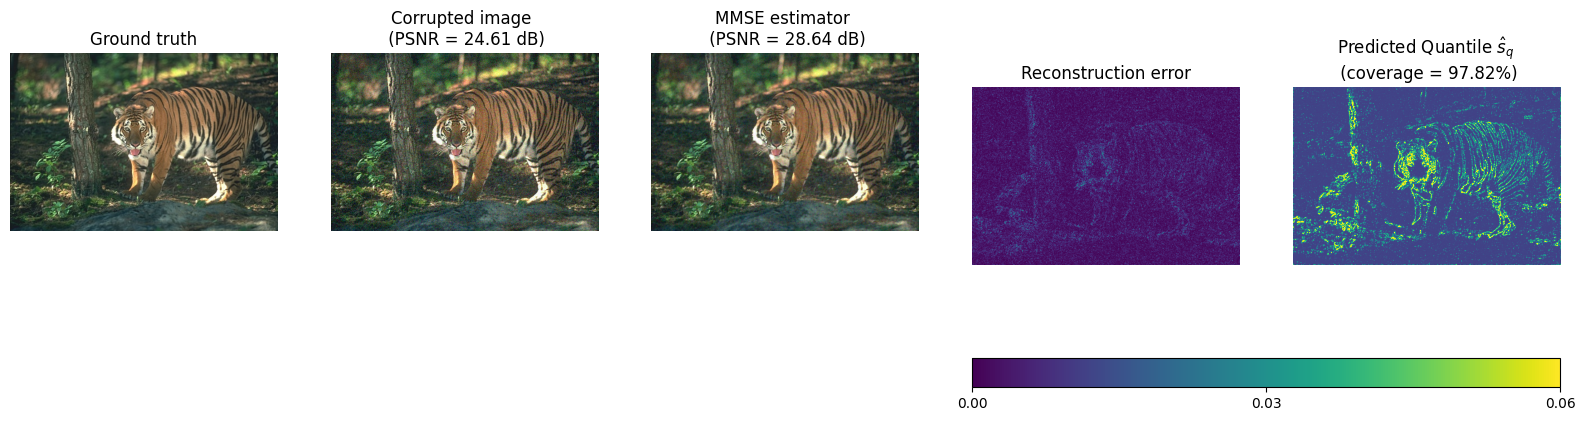

In [14]:
test_dir = "data/test"
for file in os.listdir(test_dir):
    if file.endswith(".png"):
        test_image_rgb(os.path.join(test_dir, file))

--------------------------
--------------------------
# <center> **Total Deep Variation (TDV) Denoising for RGB Images**
--------------------------
--------------------------

In [6]:
from TDV import load_TDV_network

In [7]:
model_path = 'models/TDV_model.pth'

TDV = load_TDV_network(model_path)

In [21]:
filename = 'data/test/lena_color.png'
size = 224
Resize = torchvision.transforms.Resize((size,size))
test_img =  torchvision.io.read_image(filename)
max = (torch.max(test_img))
min = (torch.min(test_img))
test_img = (test_img-min)/(max-min)
test_img = Resize(test_img)

In [28]:
u0 = torch.tensor(rgb2gray(plt.imread(filename)))
z = u0 + sigma*torch.randn_like(u0)

energies, chain_iterates = unadjusted_langevin_dynamics_TDV(TDV, z, sigma=sigma, lambda_=lamb, eps=1e-3, tau=1e-3, niter=2000)

plt.plot(energies)
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Energy of the chain')
plt.show()

  0%|          | 0/2000 [00:00<?, ?it/s]


RuntimeError: Boolean value of Tensor with more than one value is ambiguous